У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
import pandas as pd
from darts.metrics import mape
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
import numpy as np
from darts import TimeSeries
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

stores_df = pd.read_csv('csv/train.csv.zip', compression='zip')

stores_df['date'] = pd.to_datetime(stores_df['date'], format='%Y-%m-%d', errors='coerce')

stores_df.set_index('date', inplace=True)

def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

def plot_results(series, forecast):
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast)

print(stores_df.info())
print(stores_df.head())
print(stores_df.index)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB
None
            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name=

  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



In [2]:
stores_df.groupby('item').agg(
    count=('item', 'count'),
    total_stores=('store', 'nunique'),
    total_sales=('sales', 'sum')
).sort_index()

count  total_stores  total_sales
item                                  
1     18260            10       401384
2     18260            10      1069564
3     18260            10       669087
4     18260            10       401907
5     18260            10       335230
6     18260            10      1068281
7     18260            10      1068777
8     18260            10      1405108
9     18260            10       938379
10    18260            10      1337133
11    18260            10      1271925
12    18260            10      1271534
13    18260            10      1539621
14    18260            10      1071531
15    18260            10      1607442
16    18260            10       468480
17    18260            10       602486
18    18260            10      1538876
19    18260            10       736892
20    18260            10       867641
21    18260            10       736190
22    18260            10      1469971
23    18260            10       534979
24    18260            10      1205975
25    18260            10      1473334
26    18260            10       869981
27    18260            10       402628
28    18260            10      1604713
29    18260            10      1271240
30    18260            10       736554
31    18260            10      1070845
32    18260            10       803107
33    18260            10      1270183
34    18260            10       469935
35    18260            10      1201541
36    18260            10      1406548
37    18260            10       534258
38    18260            10      1470330
39    18260            10       801311
40    18260            10       534094
41    18260            10       401759
42    18260            10       669925
43    18260            10       936635
44    18260            10       536811
45    18260            10      1471467
46    18260            10      1070764
47    18260            10       401781
48    18260            10       937703
49    18260            10       535663
50    18260            10      1203009

***I want to build plot for 5 best selling items across all stores***

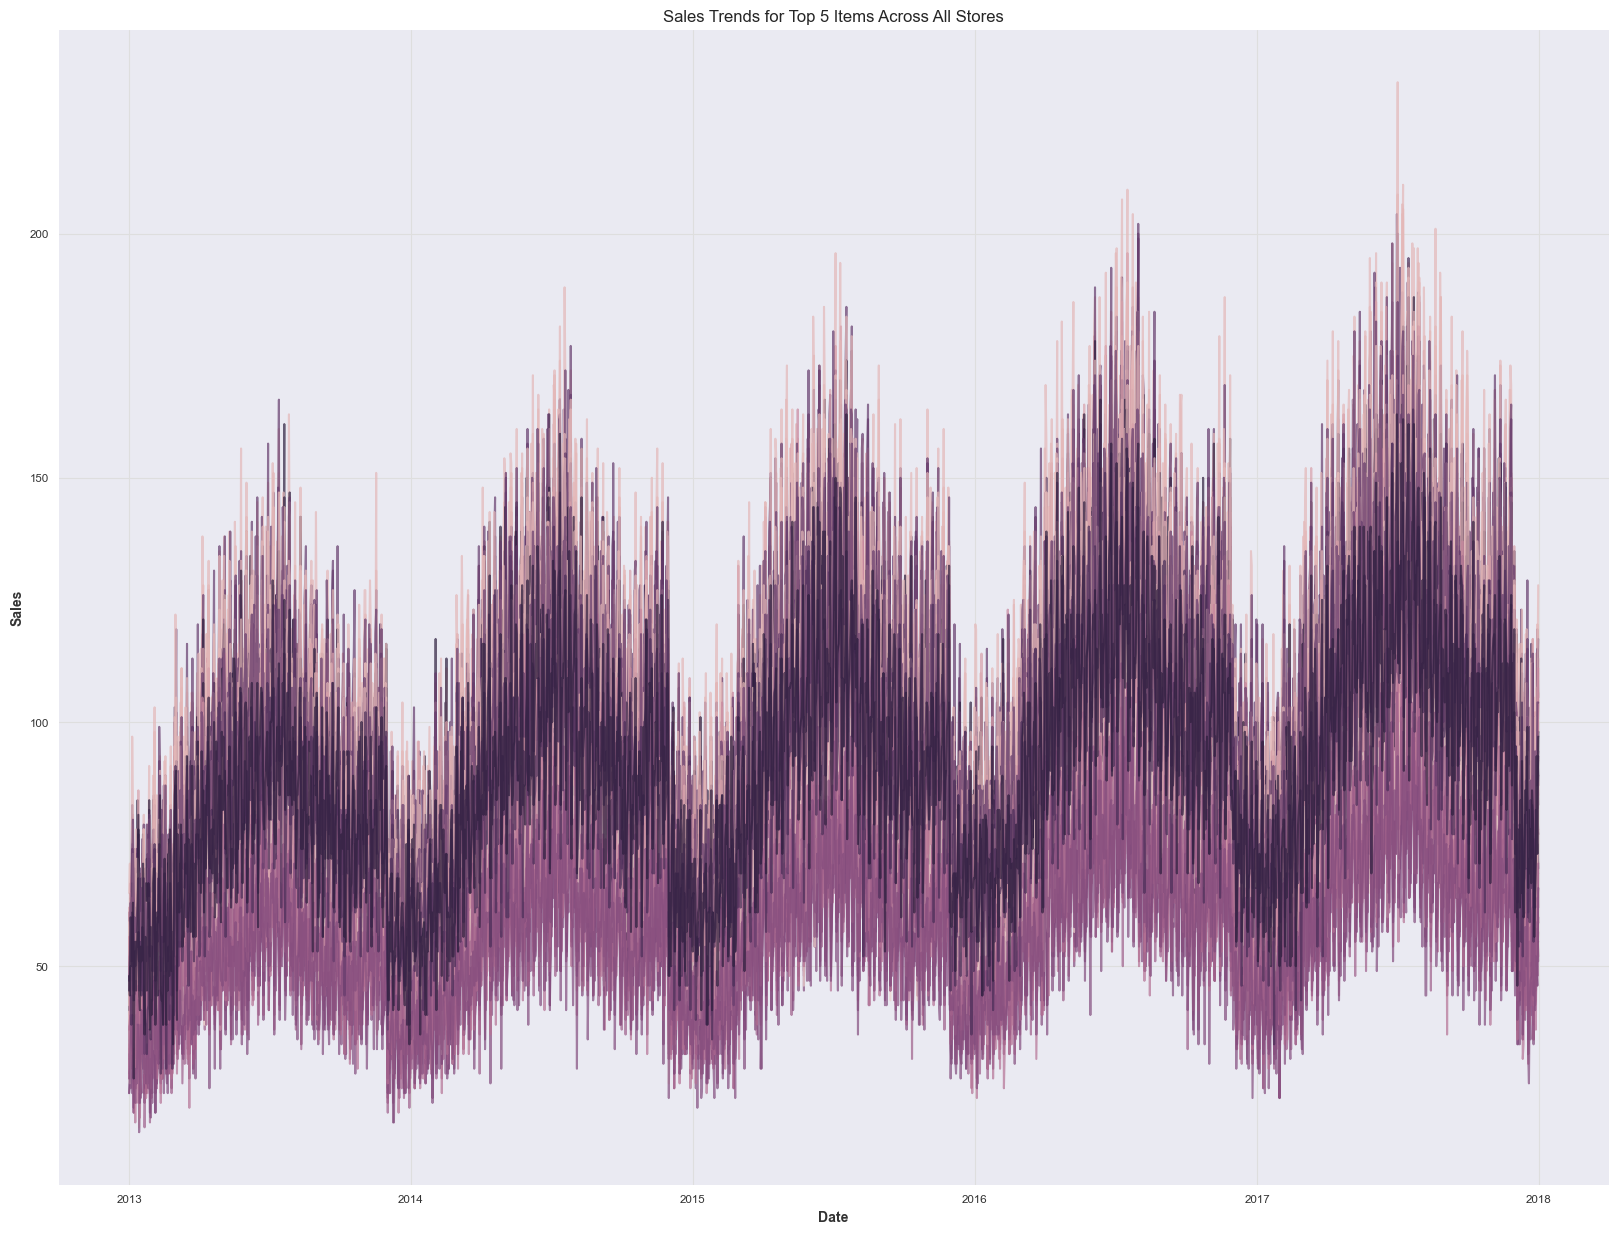

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

top_items = stores_df.groupby('item')['sales'].sum().nlargest(5).index

plt.figure(figsize=(20, 15))

for item in top_items:
    temp_df = stores_df[stores_df['item'] == item]
    sns.lineplot(data=temp_df, x='date', y='sales', hue='store', alpha=.7, linewidth=1.5, legend=False)

plt.title('Sales Trends for Top 5 Items Across All Stores')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

***Let's also build Plot af average sales per item with Confidence Intervals***

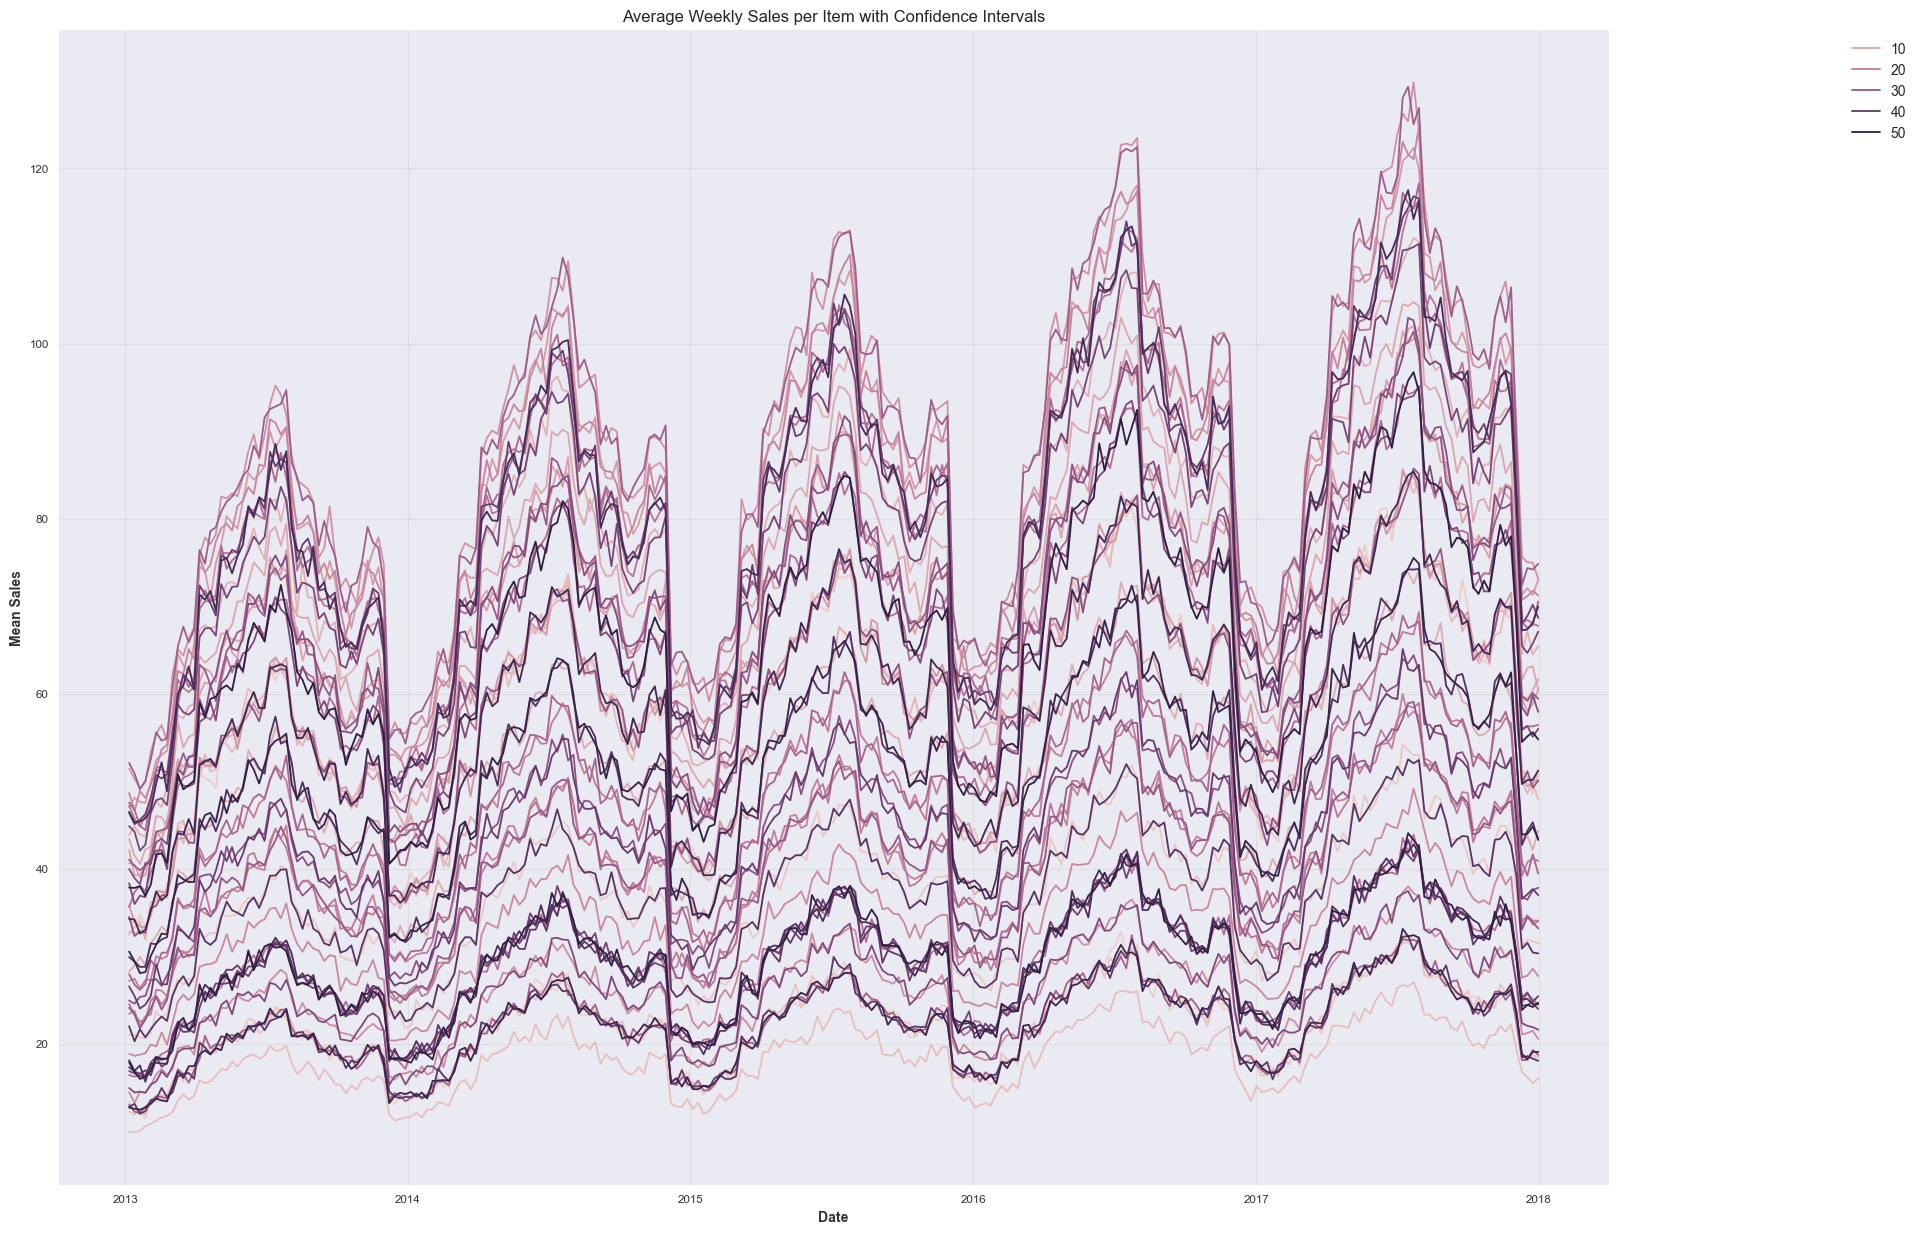

In [4]:
stores_weekly = stores_df.groupby([pd.Grouper(level=0, freq='W'), 'item'])['sales'].mean().reset_index()

plt.figure(figsize=(20, 15))
sns.lineplot(data=stores_weekly, x='date', y='sales', hue='item', estimator='mean', errorbar=('ci', 95))
plt.title("Average Weekly Sales per Item with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Mean Sales")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


***Let's also build heatmap of item sales Accross Stores***

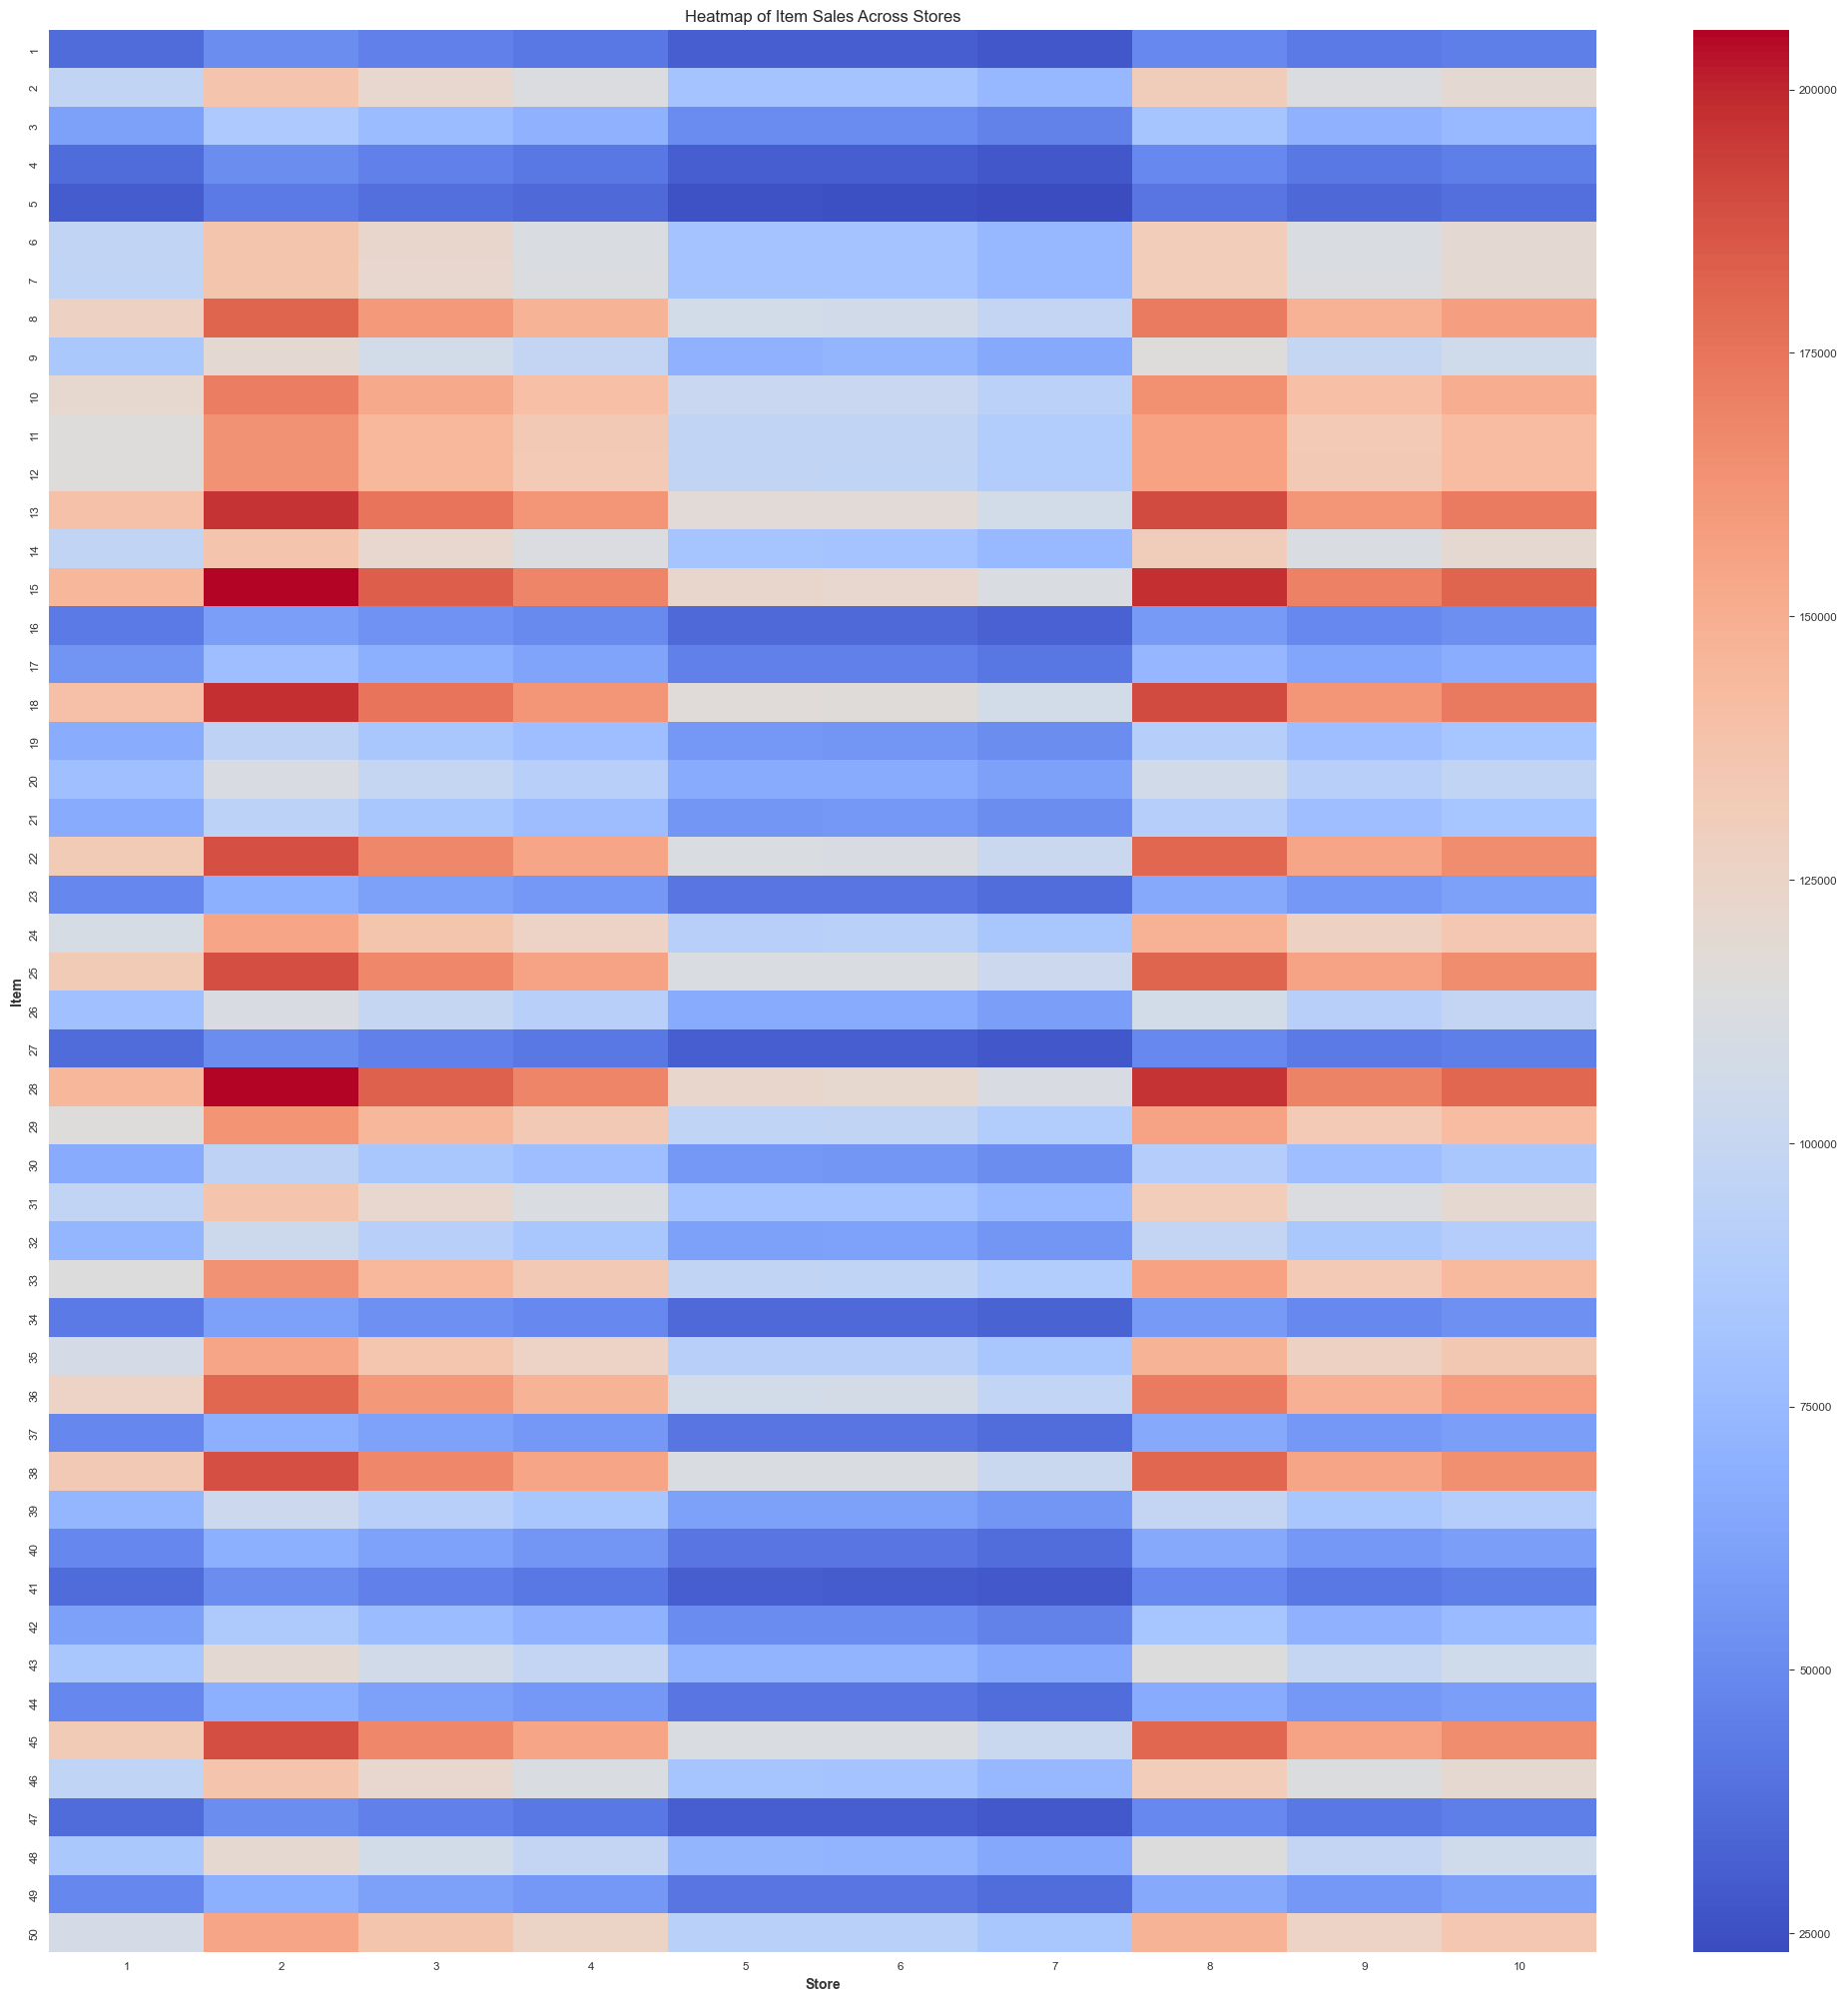

In [5]:
pivot_table = stores_df.pivot_table(index='item', columns='store', values='sales', aggfunc='sum')

plt.figure(figsize=(25, 25))
sns.heatmap(pivot_table, cmap='coolwarm', annot=False)
plt.title("Heatmap of Item Sales Across Stores")
plt.xlabel("Store")
plt.ylabel("Item")
plt.show()

***Here are my observations:***

1. First and second plot clearly show, that data has seasonality and trend.
   Seasonality may be caused by holidays, promotions and sales for example.
   Trend shows stable demand for products over time.
2. Fist and second plot are also seem to be stationary, which says that mean of sales may be relatively consistent over time.
3. Heatmap shows that sales distribution is not uniform:
   - Some stores (e.g. 2, 8, 10) have significantly higher sales for certain items.
   - Some items are not consistently sold across multiple stores.
   - Some stores sell wide variety of items
   - If some stores underperform in selling certain items, it could indicate overstocking issues
   - If some items sell explicitly well in some stores, but not others, it may be because of some regional preferences.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

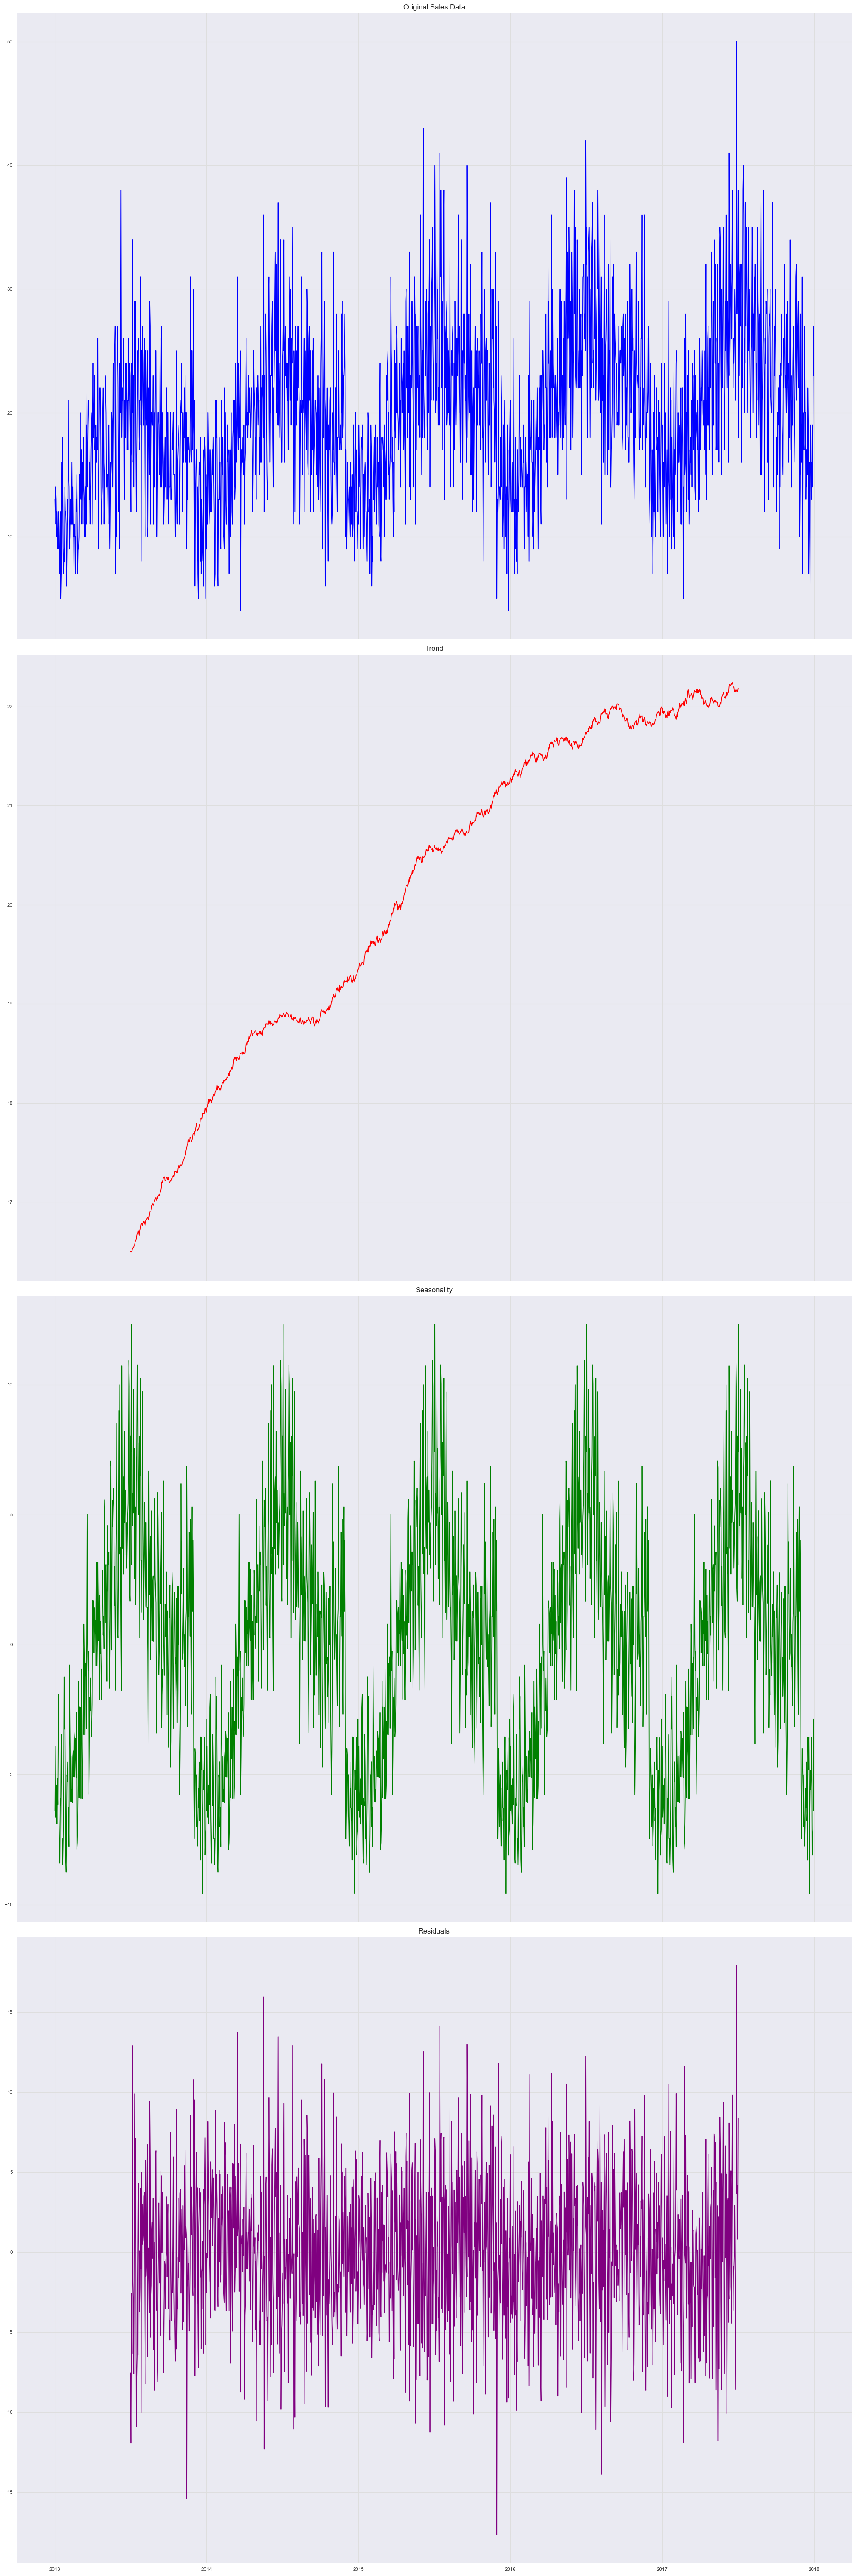

In [6]:
store_item_df = stores_df[(stores_df['item'] == 1) & (stores_df['store'] == 1)].copy()

decomposed = seasonal_decompose(store_item_df['sales'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(20, 60), sharex=True)
axes[0].plot(store_item_df['sales'], label='Original Sales Data', color='blue')
axes[0].set_title('Original Sales Data')

axes[1].plot(decomposed.trend, label='Trend', color='red')
axes[1].set_title('Trend')

axes[2].plot(decomposed.seasonal, label='Seasonality', color='green')
axes[2].set_title('Seasonality')

axes[3].plot(decomposed.resid, label='Residuals', color='purple')
axes[3].set_title('Residuals')

plt.tight_layout()
plt.show()




***Here are my conclusions:***
   1. Trend Analysis: The trend component shows an overall increasing pattern, meaning sales of item 1 in store 1 have been growing over time.
   2.	Seasonality: The seasonality plot indicates periodic fluctuations that repeat consistently, which suggests predictable demand changes throughout the year.
   3. Residuals: The residual component appears to be mostly random noise, without clear patterns. This means that the chosen decomposition period (365 days) effectively captures the trend and seasonality, leaving only unexplained variation.
   4. I can use apply a Dickey-Fuller test (ADF test) to confirm whether your time series is stationary.

***Let's implement ADF test***

In [7]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(store_item_df['sales'])

print('ADF results')
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("The time series is stationary (reject null hypothesis)")
else:
    print("The time series is non-stationary (fail to reject null hypothesis)")

ADF results
ADF Statistic: -3.1576705563328202
p-value: 0.022569380626570476
Critical values: {'1%': -3.4339840952648695, '5%': -2.8631452508003057, '10%': -2.567624583142913}
The time series is stationary (reject null hypothesis)


4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [8]:
from darts import TimeSeries

ts = TimeSeries.from_dataframe(store_item_df, value_cols='sales')
ts_last_part = ts[-100:]

print(ts)

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) <U5 20B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None


5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

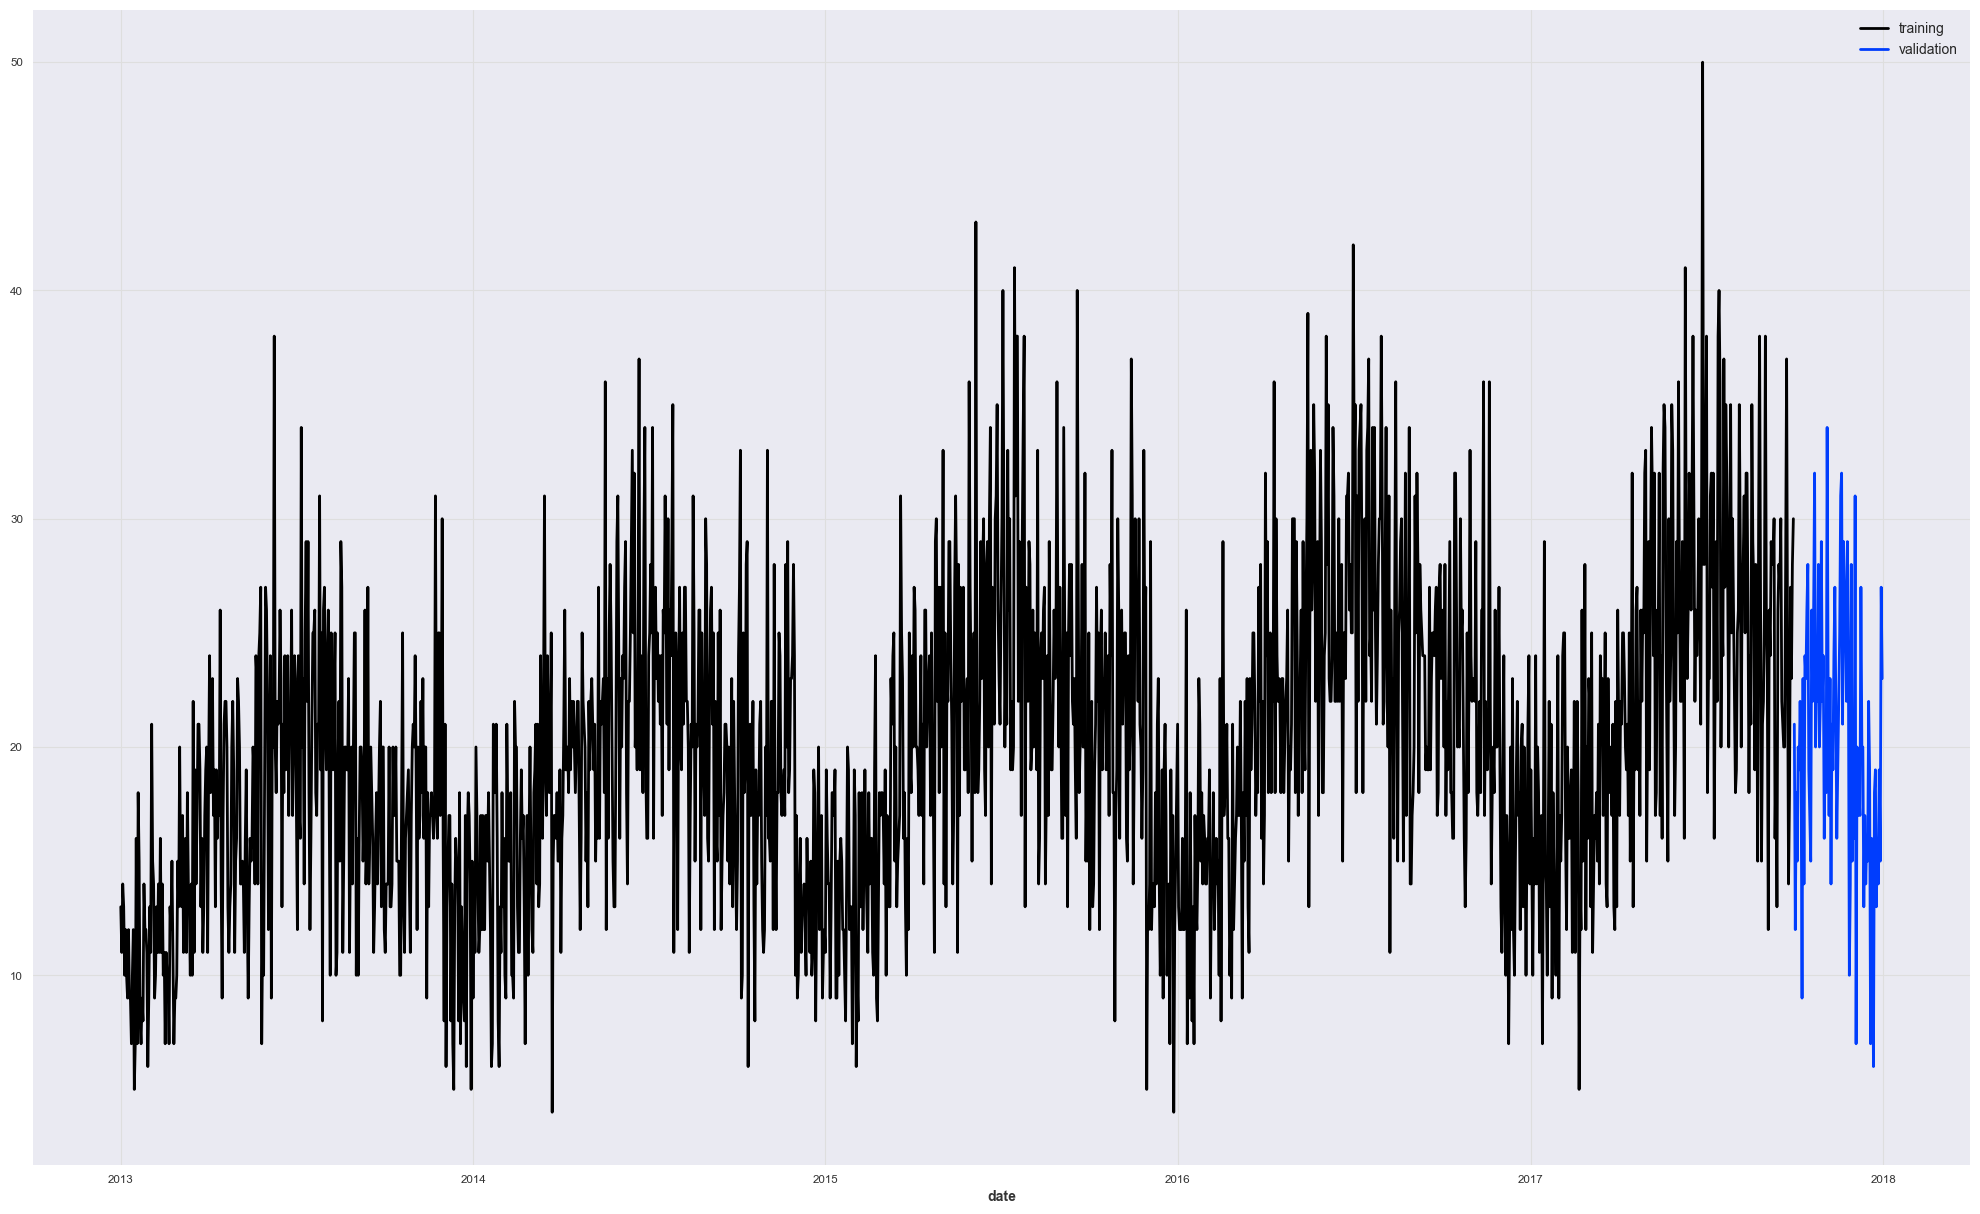

In [9]:
train, val = ts.split_before(pd.Timestamp("2017-10-01"))

plt.figure(figsize=(25, 15))  # Adjust width (15) and height (6) as needed
train.plot(label="training")
val.plot(label="validation")
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

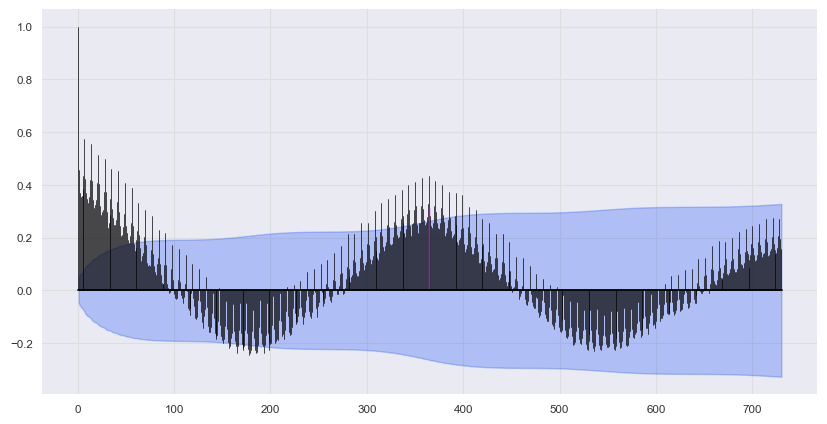

In [10]:
from darts.utils.statistics import plot_acf

plot_acf(train, m=365, alpha=0.05, max_lag=730)

As I can see, lag = 365 is significant for forecasting. There is repeating pattern at 365-day intervals. This suggests, that sales from previous year have strong relationship with current sales. The correlation decreases but lag increases and peaks every 365 days.

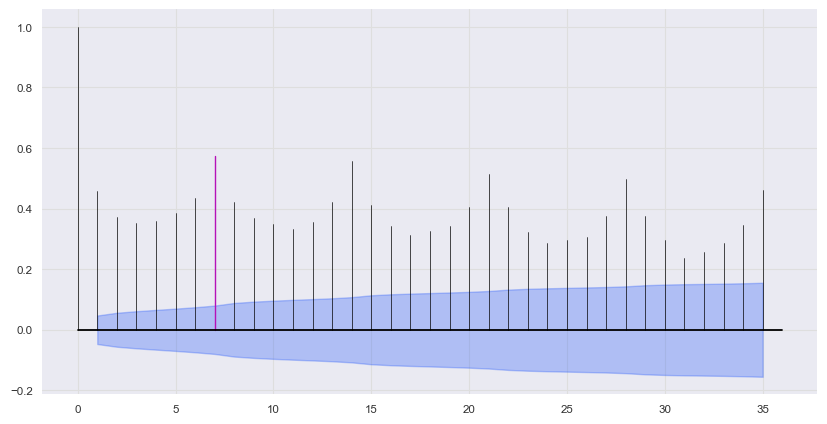

In [11]:
from darts.utils.statistics import plot_acf

plot_acf(train, m=7, alpha=0.05, max_lag=35)

We also have seasonality at lag 7. So it also can be used as lag in our future models.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [13]:
from darts.utils.statistics import check_seasonality

max_lag = 731  # Set max_lag explicitly
for m in range(2, max_lag):
    is_seasonal, period = check_seasonality(train, m=m, max_lag=max_lag, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.
There is seasonality of order 28.
There is seasonality of order 35.
There is seasonality of order 42.
There is seasonality of order 49.
There is seasonality of order 56.
There is seasonality of order 63.
There is seasonality of order 70.
There is seasonality of order 74.
There is seasonality of order 77.
There is seasonality of order 84.
There is seasonality of order 91.
There is seasonality of order 98.
There is seasonality of order 105.
There is seasonality of order 112.
There is seasonality of order 119.
There is seasonality of order 126.
There is seasonality of order 133.
There is seasonality of order 224.
There is seasonality of order 231.
There is seasonality of order 238.
There is seasonality of order 245.
There is seasonality of order 252.
There is seasonality of order 259.
There is seasonality of order 266.
There is seasonality of order 273.
There is seasonality of order 280.
T

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

<Axes: xlabel='date'>

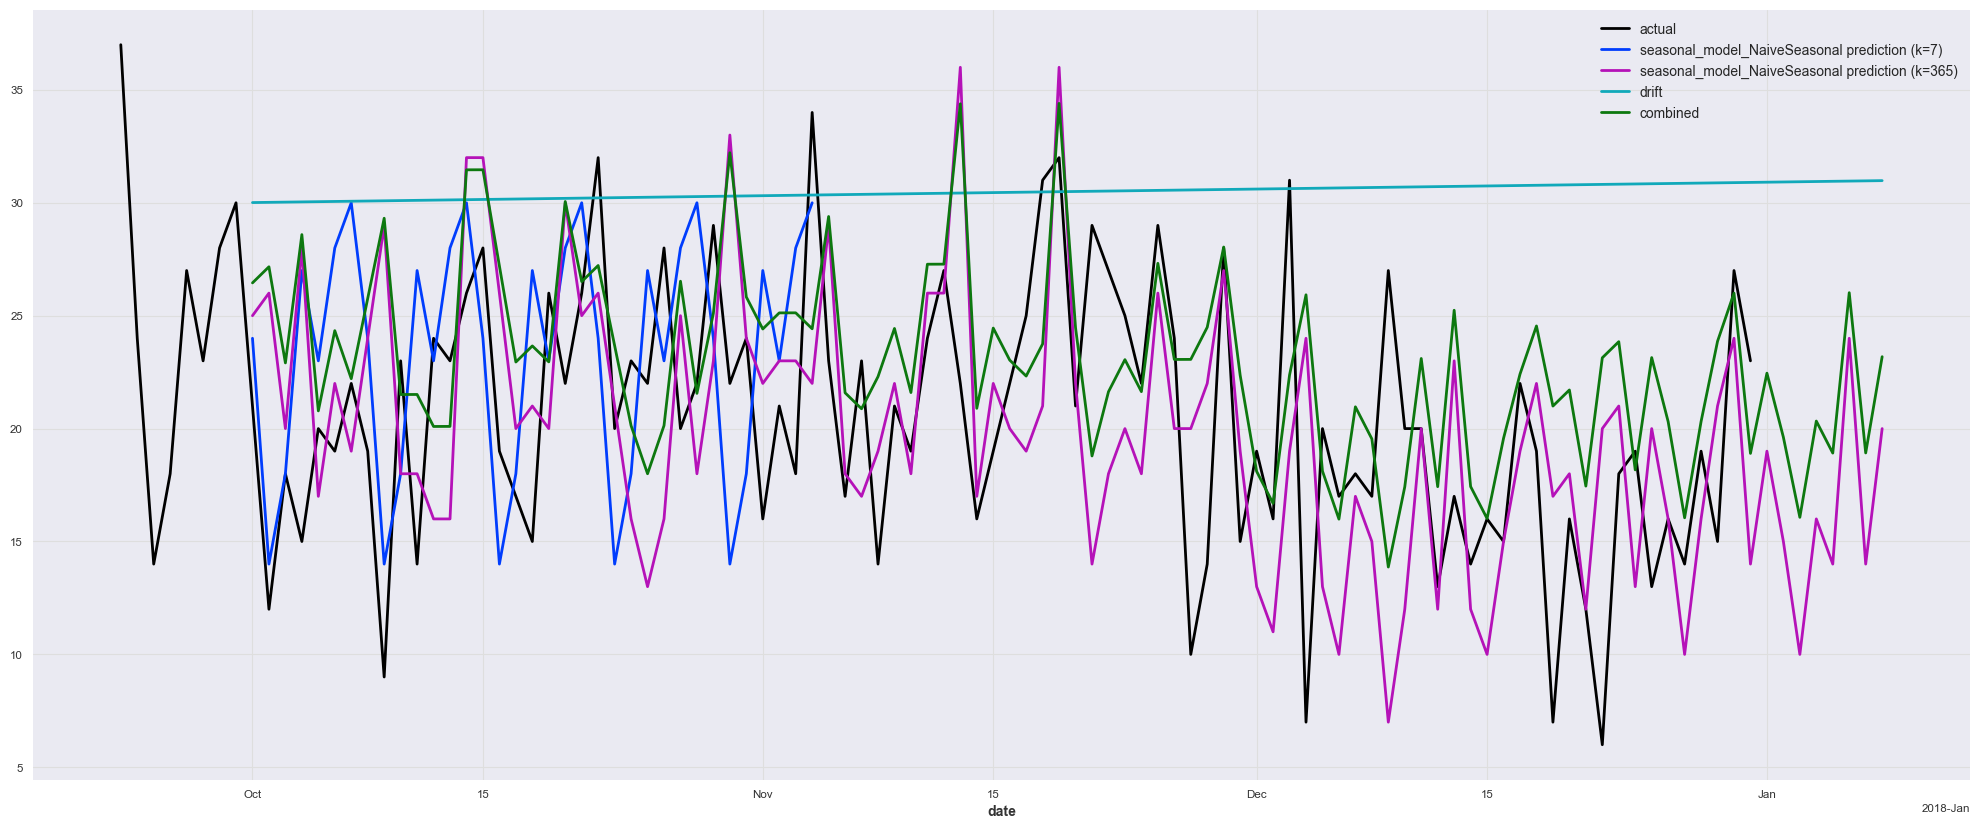

In [14]:
from darts.models import NaiveSeasonal, NaiveDrift

seasonal_model_NaiveSeasonal_7 = NaiveSeasonal(K=7)
seasonal_model_NaiveSeasonal_7.fit(train)
seasonal_model_NaiveSeasonal_7_forecast = seasonal_model_NaiveSeasonal_7.predict(35)

seasonal_model_NaiveSeasonal_365 = NaiveSeasonal(K=365)
seasonal_model_NaiveSeasonal_365.fit(train)
seasonal_model_NaiveSeasonal_forecast_365 = seasonal_model_NaiveSeasonal_365.predict(100)

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(100)

#Combine NaiveDrift and NaiveSeasonal for better forecasting
# Use a weighted sum to balance drift influence
alpha = 0.29  # Adjust this weight based on observed results
combined_forecast = (1 - alpha) * seasonal_model_NaiveSeasonal_forecast_365 + alpha * drift_forecast

plt.figure(figsize=(25, 10))  # Adjust width (15) and height (6) as needed
ts_last_part.plot(label="actual")
seasonal_model_NaiveSeasonal_7_forecast.plot(label="seasonal_model_NaiveSeasonal prediction (k=7)")
seasonal_model_NaiveSeasonal_forecast_365.plot(label="seasonal_model_NaiveSeasonal prediction (k=365)")
drift_forecast.plot(label="drift")
combined_forecast.plot(label="combined")

As I can see all three models: NaiveSeasonal, NaiveDrift, and the combined model dot not capture true trend and variability.

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [15]:
print(
    f"Mean absolute percentage error for the seasonal_model_NaiveSeasonal_7: {mape(ts, seasonal_model_NaiveSeasonal_7_forecast):.2f}%."
)

print(
    f"Mean absolute percentage error for the seasonal_model_NaiveSeasonal_forecast_365: {mape(ts, seasonal_model_NaiveSeasonal_forecast_365):.2f}%."
)

print(
    f"Mean absolute percentage error for the drift_forecast: {mape(ts, drift_forecast):.2f}%."
)


print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(ts, combined_forecast):.2f}%."
)

Mean absolute percentage error for the seasonal_model_NaiveSeasonal_7: 29.89%.
Mean absolute percentage error for the seasonal_model_NaiveSeasonal_forecast_365: 33.92%.
Mean absolute percentage error for the drift_forecast: 68.74%.
Mean absolute percentage error for the combined naive drift + seasonal: 35.79%.


As we can see, all models have quite big MAPE error.

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [53]:
def enrich_data_with_new_features(df: pd.DataFrame) -> pd.DataFrame:
    df["date"] = pd.to_datetime(df.index, errors="coerce")

    df["dayofweek"] = df["date"].dt.dayofweek
    # df["month"] = df["date"].dt.month
    # df["year"] = df["date"].dt.year
    # df["dayofyear"] = df["date"].dt.dayofyear
    # df["sin_day"] = np.sin(df['dayofyear'])
    # df["cos_day"] = np.cos(df['dayofyear'])

    df.drop(columns=["date"], inplace=True, errors="ignore")
    df.drop(columns=["component"], inplace=True, errors="ignore")

    return df

#Step 1: Transform Data
train_transformed = enrich_data_with_new_features(train.to_dataframe())
val_transformed = enrich_data_with_new_features(val.to_dataframe())

#Step 2: Convert to TimeSeries
train_ts_transformed = TimeSeries.from_dataframe(train_transformed, fill_missing_dates=True, freq="D")
val_ts_transformed = TimeSeries.from_dataframe(val_transformed, fill_missing_dates=True, freq="D")

#Step 3: Scale Data
scaler = Scaler()
train_scaled = scaler.fit_transform(train_ts_transformed)
val_scaled = scaler.transform(val_ts_transformed)

#Step 5: Train XGBModel
xgb_model = XGBModel(
    lags=365,
    output_chunk_length=7,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
)

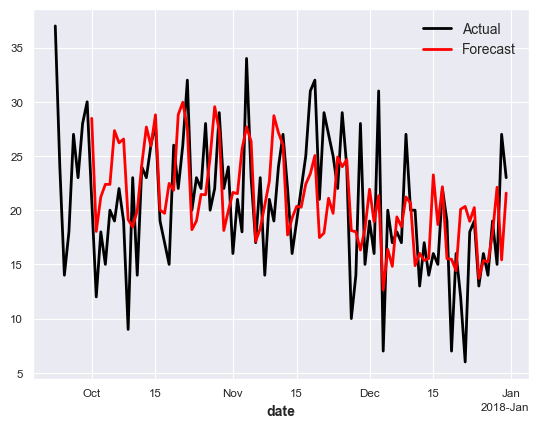

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 25.92%


In [54]:
fit_and_plot(xgb_model, ts_last_part, train, val)

I can say that XGBoost model is slightly better than previous models.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

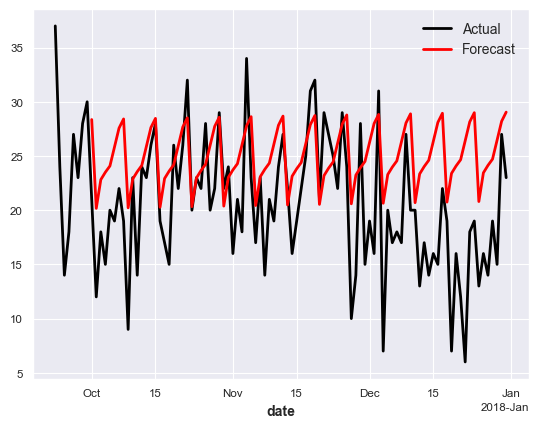

model ExponentialSmoothing() obtains MAPE: 38.94%


In [38]:
from darts.models import ExponentialSmoothing

model_exponential = ExponentialSmoothing()
fit_and_plot(model_exponential, ts_last_part, train, val)

This model is worse than XgBoost model.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

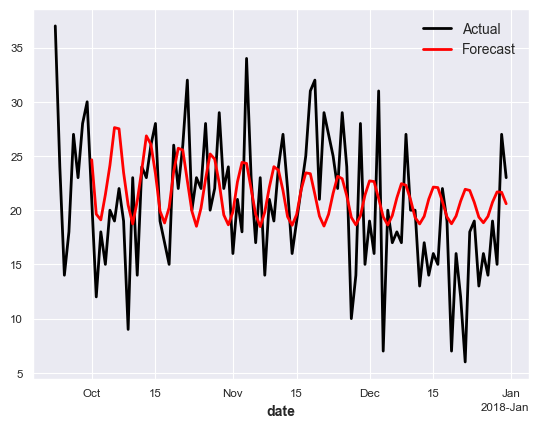

model ARIMA(d=0, q=3) obtains MAPE: 29.18%


In [39]:
from darts.models import ARIMA

model = ARIMA(p=12, d=0, q=3)
fit_and_plot(model, ts_last_part, train, val)

As I can see ARIMA model gave slightly better result than ExponentialSmoothing, but still not as good as XGBModel

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

Optimal ARIMA Parameters: {'D': None, 'alpha': 0.05, 'd': None, 'error_action': 'trace', 'information_criterion': 'aic', 'm': 7, 'max_D': 1, 'max_P': 2, 'max_Q': 2, 'max_d': 2, 'max_order': 5, 'max_p': 12, 'max_q': 12, 'maxiter': 50, 'method': 'lbfgs', 'n_fits': 10, 'n_jobs': 1, 'offset_test_args': None, 'out_of_sample_size': 0, 'random': False, 'random_state': None, 'scoring': 'mse', 'scoring_args': None, 'seasonal': True, 'seasonal_test': 'ocsb', 'seasonal_test_args': None, 'start_P': 1, 'start_Q': 1, 'start_p': 0, 'start_params': None, 'start_q': 0, 'stationary': False, 'stepwise': True, 'suppress_warnings': True, 'test': 'kpss', 'trace': False, 'trend': None, 'with_intercept': 'auto'}
MAPE of AutoARIMA model: 38.00%


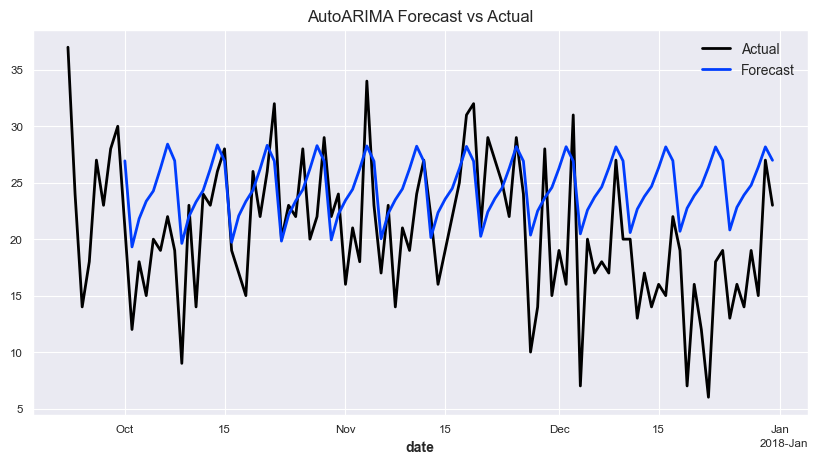

In [70]:
from darts.models import AutoARIMA


model = AutoARIMA(start_p=0, max_p=12, start_q=0, max_q=12, seasonal=True, m=7)
model.fit(train)
best_params = model.model.get_params()
print(f"Optimal ARIMA Parameters: {best_params}")

forecast = model.predict(len(val))

# Compute error metrics
error = mape(val, forecast)
print(f"MAPE of AutoARIMA model: {error:.2f}%")

# Plot actual vs. forecast
plt.figure(figsize=(10, 5))
ts_last_part.plot(label="Actual")
forecast.plot(label="Forecast")
plt.legend()
plt.title("AutoARIMA Forecast vs Actual")
plt.show()

In [69]:
model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1734
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5286.539
Date:                Wed, 12 Mar 2025   AIC                          10591.078
Time:                        21:07:51   BIC                          10640.196
Sample:                             0   HQIC                         10609.244
                               - 1734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.038      0.905      0.365      -0.040       0.109
ar.L2         -0.0798      0.034     -2.376      0.018      -0.146      -0.014
ar.L3         -0.0775      0.033     -2.317      0.020      -0.143      -0.012
ar.L4         -0.0650      0.034     -1.936      0.053      -0.131       0.001
ar.L5         -0.0342      0.032     -1.064      0.287      -0.097       0.029
ar.L6          0.0063      0.030      0.209      0.834      -0.053       0.065
ar.L7          0.2638      0.029      9.044      0.000       0.207       0.321
ma.L1         -0.9071      0.026    -34.258      0.000      -0.959      -0.855
sigma2        26.0958      0.820     31.811      0.000      24.488      27.704
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As a result we have SARIMAX model with such params:
 - Non-Seasonal Component: p=3, d=1, q=1
 - Seasonal Component: P=1, D=0, Q=[1,2], m=7

Model expects strong weekly pattern m=7.

It uses both seasonal and non-seasonal components to capture short-term trends and seasonal variations.

It applies one level differencing to remove any non-stationary trends.

But still model gives quite high mistake percentage.

14. Натренуйте модель Prophet та зробіть висновок про її якість.

21:43:36 - cmdstanpy - INFO - Chain [1] start processing
21:43:37 - cmdstanpy - INFO - Chain [1] done processing


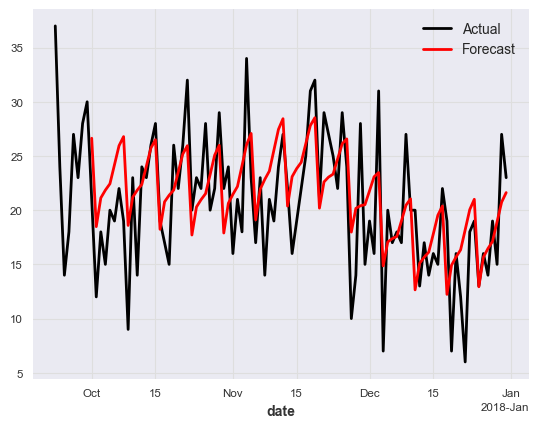

MAPE of Prophet model: 23.81%


In [16]:
from darts.models import Prophet

# Побудова та тренування моделі Prophet
model = Prophet()
model.fit(train)

# Прогнозування
forecast = model.predict(len(val))

# Візуалізація результатів
ts_last_part.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

error = mape(val, forecast)
print(f"MAPE of Prophet model: {error:.2f}%")

This model is the best so far.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

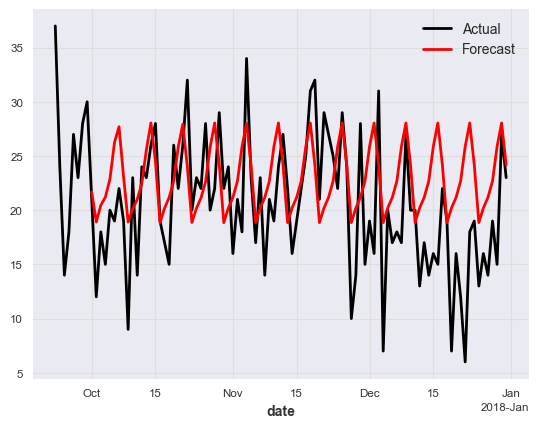

In [31]:
from darts.models import RNNModel
import torch
torch.set_default_dtype(torch.float32)

# Побудова та тренування моделі LSTM
train32 = train.astype(np.float32)
model = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=300)
model.fit(train32)

# Прогнозування
forecast = model.predict(len(val))

# Візуалізація результатів
ts_last_part.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [32]:
error = mape(val, forecast)
print(f"MAPE of RNNModel model: {error:.2f}%")

MAPE of RNNModel model: 32.88%


This model also does not show good results.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [ ]:
best_model = Prophet()
best_model.fit(train)
forecast = best_model.predict(len(val))
eval_forecast(best_model, val, forecast)

historical forecasts:   0%|          | 0/11 [00:00<?, ?it/s]

22:12:29 - cmdstanpy - INFO - Chain [1] start processing
22:12:29 - cmdstanpy - INFO - Chain [1] done processing
22:12:29 - cmdstanpy - INFO - Chain [1] start processing
22:12:29 - cmdstanpy - INFO - Chain [1] done processing
22:12:29 - cmdstanpy - INFO - Chain [1] start processing
22:12:30 - cmdstanpy - INFO - Chain [1] done processing
22:12:30 - cmdstanpy - INFO - Chain [1] start processing
22:12:30 - cmdstanpy - INFO - Chain [1] done processing
22:12:30 - cmdstanpy - INFO - Chain [1] start processing
22:12:30 - cmdstanpy - INFO - Chain [1] done processing
22:12:30 - cmdstanpy - INFO - Chain [1] start processing
22:12:30 - cmdstanpy - INFO - Chain [1] done processing
22:12:30 - cmdstanpy - INFO - Chain [1] start processing
22:12:30 - cmdstanpy - INFO - Chain [1] done processing
22:12:30 - cmdstanpy - INFO - Chain [1] start processing
22:12:30 - cmdstanpy - INFO - Chain [1] done processing
22:12:30 - cmdstanpy - INFO - Chain [1] start processing
22:12:30 - cmdstanpy - INFO - Chain [1]

MAPE = 20.58%


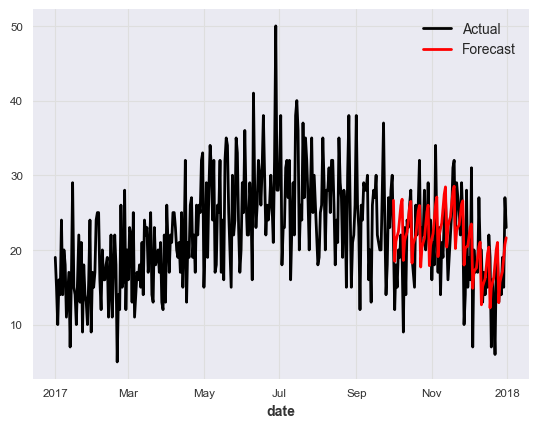

In [28]:
from darts import concatenate

hfc_params = {
    "series": ts,
    "start": pd.Timestamp("2017-01-01"),  # Start backtesting from 1 year before the end
    "forecast_horizon": 31,  # Predict 1 month ahead at each step
    "stride": 31,  # Update forecast every 31 days
    "last_points_only": False,  # Show full forecasted periods
    "verbose": True,
}

# Run historical forecasts
historical_fcast_list = best_model.historical_forecasts(**hfc_params)

# Combine all forecasted periods into a single TimeSeries object
historical_fcast = concatenate(historical_fcast_list, axis=0)

ts[-365:].plot(label='Actual')
forecast.plot(label='Forecast', color='red')

# Align with actual data (only take overlapping period)
actual_series = ts.slice_intersect(historical_fcast)

# Compute MAPE using only overlapping actual vs. predicted data
print(f"MAPE = {mape(actual_series, historical_fcast):.2f}%")

Всю варіантивність не вгадали, але виглядає непогано!

As I can see, the best model so far is - Facebook Prophet has shown MAPE = 20.58% during backtasting.

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Despite the fact, that Facebook Prophet has shown the best result in my notebook, it is not suitable to forecasting of each item sales in each shop. The only model capable to do that is XGBoost (or LightGBM).

Such task will require only one model. The output will be sales for each item in each shop.

XGBoost (or LightGBM) is capable of processing large data volumes and can capture data and store trends. Besides that later I can add new data to my model, such as promotions or holidays.

But XGBoost (or LightGBM) should be treated with caution and tuned precisely in terms of feature engineering.
Besides that, XGBoost (or LightGBM) is quite heavy when we talk about computational complexity, but it is still lighter than training 50x10 models.
